In [1]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import json

%matplotlib inline

table_prefix = 'test'
limit = 10000
forward_days = 365

with open ('../params.json') as f:
    params = json.load(f)
    
table_prefix = params['table_prefix']
diseases = params['diseases']
case_limit = params['case_limit']
control_limit = params['control_limit']
min_enrollment = params['enrollment']
user = params['user']
num_icds = 200

chunk = True


name = '' 
for key, val in diseases.items():
    name += key + '_'
print(name[:-1])

Parkinsons_EssentialTremor


In [2]:
df_dict = {}
nn_dict = {}
neighbors = {}
for i in [30, 90, 180, 365]:
    print(i)
    df_dict[i] = pd.read_csv('/home/bkb12/data/clustering/' + 
                             name[:-1] + str(i) + '.csv.gz', compression='gzip')
    df_dict[i].drop(['MemberNum'], inplace=True, axis=1)
#     nn_dict[i] = NearestNeighbors(n_neighbors=10).fit(df_dict[i])
#     _, neighbors[i] = nn_dict[i].kneighbors(df_dict[i])

30
90
180
365


# Let's first evaluate logistic regression 

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import numpy as np
# from sklearn.model_selection import StratifiedKFold

scores = {}
for i in [30, 90, 180, 365]:
    X = df_dict[i].values[:, :-1]
    y = (df_dict[i].astype(int)-332).values[:, -1]
    print(np.unique(y))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    clf = LogisticRegression(C=0.1, penalty='l2', tol=0.01).fit(X_train, y_train)
    scores[i] = cross_val_score(clf, X_test, y_test, scoring='roc_auc', cv=10, n_jobs=4)
    print(sum(scores[i])/len(scores[i]))
    print(scores[i])

[0 1]
0.714132574876872
[0.70606965 0.66267413 0.75643035 0.64222637 0.727225   0.73165
 0.70937186 0.75217337 0.6961809  0.75732412]
[0 1]
0.728181054963874
[0.71606965 0.68528607 0.7516791  0.68190299 0.754925   0.7749
 0.72692211 0.73893216 0.70623116 0.74496231]
[0 1]
0.7414851957861447
[0.73475124 0.69863184 0.75597015 0.68835821 0.7530125  0.771025
 0.75140704 0.75802764 0.74748744 0.7561809 ]
[0 1]
0.752842627878197
[0.73539801 0.70032338 0.76875622 0.71847015 0.7566     0.763175
 0.76771357 0.78776382 0.7440201  0.78620603]


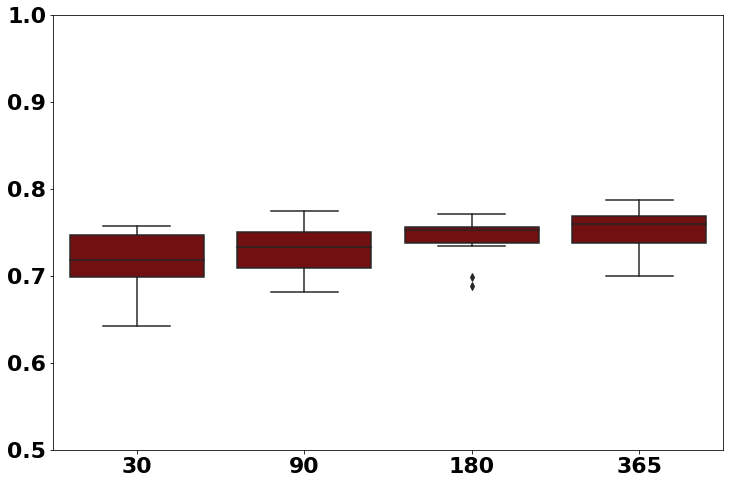

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
scores_df = pd.DataFrame.from_dict(scores)
ax = sns.boxplot(data=scores_df, color='maroon')
ax.set_ylim([0.5, 1])
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [6]:
for key in df_dict.keys():
    df_dict[key].drop('label', axis=1, inplace=True)

# Now Compare Comorbidity Matrices

In [7]:
from sklearn.metrics.pairwise import euclidean_distances
dist30 = euclidean_distances(df_dict[30], df_dict[30])
print('30')
dist90 = euclidean_distances(df_dict[90], df_dict[90])
print('90')
dist180 = euclidean_distances(df_dict[180], df_dict[180])
print('180')
dist365 = euclidean_distances(df_dict[365], df_dict[365])
print('365')

30
90
180
365


In [8]:
import numpy as np
print(type(dist30), dist30.shape)
N = 101 # 11 because same will always be smallest
neighbors30 = np.argsort(-dist30, axis=0)[-1:-1-N:-1]
print('30')
neighbors90 = np.argsort(-dist90, axis=0)[-1:-1-N:-1]
print('90')
neighbors180 = np.argsort(-dist180, axis=0)[-1:-1-N:-1]
print('180')
neighbors365 = np.argsort(-dist365, axis=0)[-1:-1-N:-1]
print('365')

(<type 'numpy.ndarray'>, (20000, 20000))
30
90
180
365


In [9]:
print(neighbors30.shape, neighbors30[0].shape)

((101, 20000), (20000,))


In [10]:
total_count = 0
c30_90 = 0
c30_180 = 0
c30_365 = 0
c90_180 = 0
c90_365 = 0
c180_365 = 0

for i in range(neighbors30.shape[1]): 
    for j in range(1, neighbors30.shape[0]):
        total_count +=1
        if neighbors30[j, i] in neighbors90[1:, i]:
            c30_90 += 1
        if neighbors30[j, i] in neighbors180[1:, i]:
            c30_180 += 1
        if neighbors30[j, i] in neighbors365[1:, i]:
            c30_365 += 1
        if neighbors90[j, i] in neighbors180[1:, i]:
            c90_180 += 1
        if neighbors90[j, i] in neighbors365[1:, i]:
            c90_365 += 1
        if neighbors180[j, i] in neighbors365[1:, i]:
            c180_365 += 1    
print(total_count, c30_90, c30_180, c30_365, c90_180, c90_365, c180_365)

(2000000, 338580, 192688, 136509, 524287, 181112, 340981)


In [11]:
from __future__ import division
print(c30_90/total_count, c30_180/total_count, c30_365/total_count, c90_180/total_count, 
      c90_365/total_count, c180_365/total_count)

(0.16929, 0.096344, 0.0682545, 0.2621435, 0.090556, 0.1704905)


MultiIndex(levels=[[False, True], [False, True], [False, True], [False, True]],
           labels=[[1, 1, 1, 0, 0, 0], [1, 0, 0, 1, 1, 0], [0, 1, 0, 1, 0, 1], [0, 0, 1, 0, 1, 1]],
           names=[u'30day', u'90day', u'180day', u'365day'])


/home/anaconda/anaconda3/envs/py27/lib/python2.7/site-packages/upsetplot/plotting.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  totals.append(data.loc[idxslice].sum())
/home/anaconda/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/anaconda/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


{'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fc8d4b154d0>,
 'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fc8d4b49cd0>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fc8d4b8fe10>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fc8d4a692d0>}

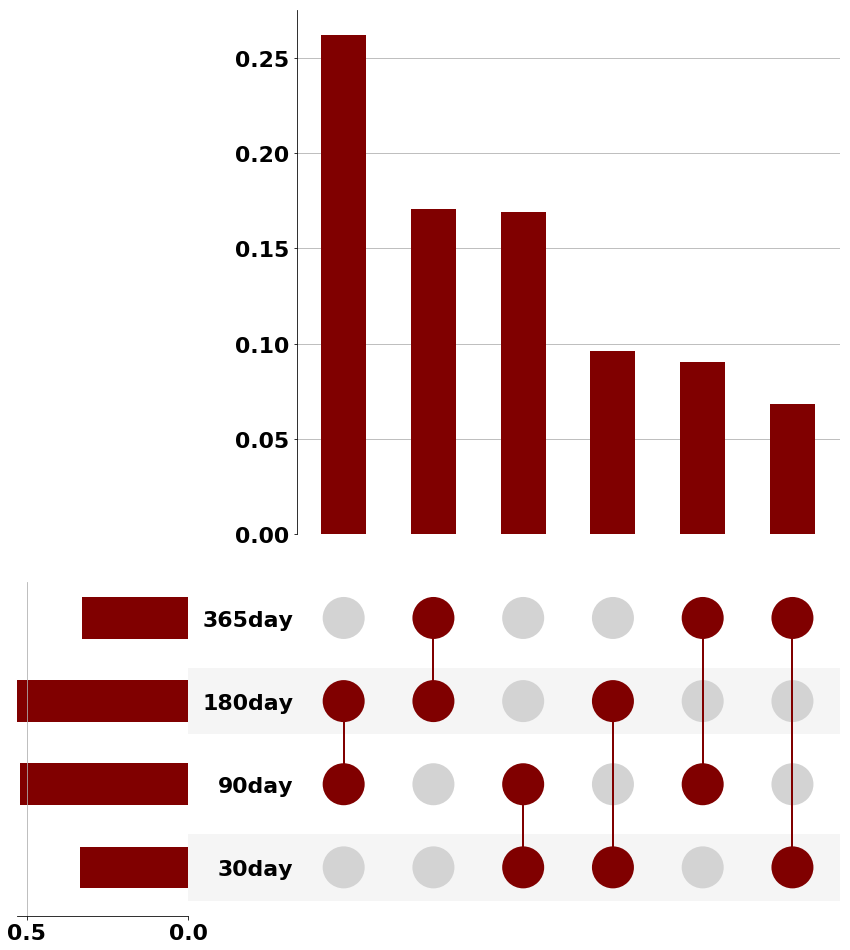

In [12]:
import matplotlib
from upsetplot import plot

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

# axes = {'edgecolor': 'white',
#         'facecolor': 'black',
#         'labelcolor': 'white'}

matplotlib.rc('font', **font)
# matplotlib.rc('axes', **axes)

# import matplotlib as mpl
# mpl.rcParams['lines.color'] = 'white'
# mpl.rcParams['text.color'] = 'maroon'
# mpl.rcParams['xtick.color'] = 'white'
# mpl.rcParams['ytick.color'] = 'maroon'
# mpl.rcParams['figure.facecolor'] = 'black'
# mpl.rcParams['legend.facecolor'] = 'black'


index = pd.MultiIndex(levels=[[False, True], [False, True], [False, True], [False, True]],
                              labels=[[1, 1, 1, 0, 0, 0],[1, 0, 0, 1, 1, 0],
                                      [0, 1, 0, 1, 0, 1], [0, 0, 1, 0, 1, 1]],
                              names=['30day', '90day', '180day', '365day'])
print(index)
count_series = pd.Series([c30_90/total_count, c30_180/total_count, 
                          c30_365/total_count, c90_180/total_count, 
                          c90_365/total_count, c180_365/total_count],
                         index=index)
plot(count_series, sort_sets_by=None, sort_by='cardinality', element_size=120, facecolor='maroon')